# Start Pred

In [15]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
picklefile = open(f'../../data/time_series_data/old/tsdata_all hex', 'rb')
#pickle the dataframe
tsdata = pickle.load(picklefile)
#close file
picklefile.close()


In [16]:
# ADD Weather Features

dfw = pd.read_csv('/Users/jonweske/devment/BA_nextbike/data/weather_data.csv')
dfw['datetime'] = pd.to_datetime(dfw['dt'], unit='s')
dfw = dfw.set_index(['datetime'])
dfw.head()

tsdata['temp'] = np.nan
tsdata['rain'] = np.nan
tsdata['snow'] = np.nan

for ind in tqdm(tsdata.index):
    wint = ind.replace(hour=12, minute=0, second=0)
    tsdata['temp'][ind] = dfw['temp'][wint].copy()
    tsdata['rain'][ind] = dfw['rain_1h'][wint].copy()
    tsdata['snow'][ind] = dfw['snow_1h'][wint].copy()

# Feature Engeniering
# inserting new column with yesterday last_week and last_year plus Diffs
tsdata['Yesterday'] = tsdata['idle_time'].shift()
tsdata['Yesterday_Diff'] = tsdata['Yesterday'].diff()

tsdata['Last_Week'] = tsdata['idle_time'].shift(periods=7)
tsdata['Last_Week_Diff'] = tsdata['Last_Week'].diff()

tsdata['Last_Year'] = tsdata['idle_time'].shift(periods=365)
tsdata['Last_Year_Diff'] = tsdata['Last_Year'].diff()

# Nan s to 0
tsdata = tsdata.fillna(0)

100%|██████████| 1460/1460 [00:02<00:00, 627.58it/s]


In [20]:
export = tsdata.reindex(columns=['idle_time','Yesterday','Yesterday_Diff','Last_Week','Last_Week_Diff','Last_Year','Last_Year_Diff','bike_count','temp','rain','snow'])
export.to_csv('../../data/tsdata-export.csv')

In [3]:
# Split Dataset

from sklearn.model_selection import train_test_split

TargetVariable = ['idle_time']
Predictors = ['bike_count', 'temp', 'rain', 'snow', 'Yesterday', 'Yesterday_Diff', 'Last_Week', 'Last_Week_Diff', 'Last_Year', 'Last_Year_Diff','bike_count']
X = tsdata[Predictors]
y = tsdata[TargetVariable]

# no shuffle because
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1095, 11)
(1095, 1)
(365, 11)
(365, 1)


In [4]:
import sklearn.metrics as metrics

def regression_results(y_true, y_pred):
    #explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mae=metrics.mean_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    #print('explained_variance: ', round(explained_variance,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mae,4))
    print('MSE: ', round(mse,4))

In [7]:
# fit, predict and display model#

def start_model(_model,_X_train,_y_train,_X_test,_y_test):
    # fit given model
    model.fit(_X_train.values,_y_train.values.ravel())

    #give Predicted y Dates as index
    _y_pred = pd.DataFrame({'date': _X_test.index, 'idle_time': model.predict(_X_test.values)})
    _y_pred = _y_pred.set_index('date')

    #print Regression Results
    print(regression_results(_y_test.values,_y_pred.values))

    # plot predicted and real y
    plt.subplots(figsize = (30,10))
    # plot Training Data ?
    #plt.plot(_y_train, color='0.2')

    plt.plot(_y_pred, color='blue', label='predicted')
    plt.plot(_y_test, color='green', label='real')
    plt.legend()
    plt.show()

r2:  0.7272
MAE:  79.2001
MSE:  10629.4427
None


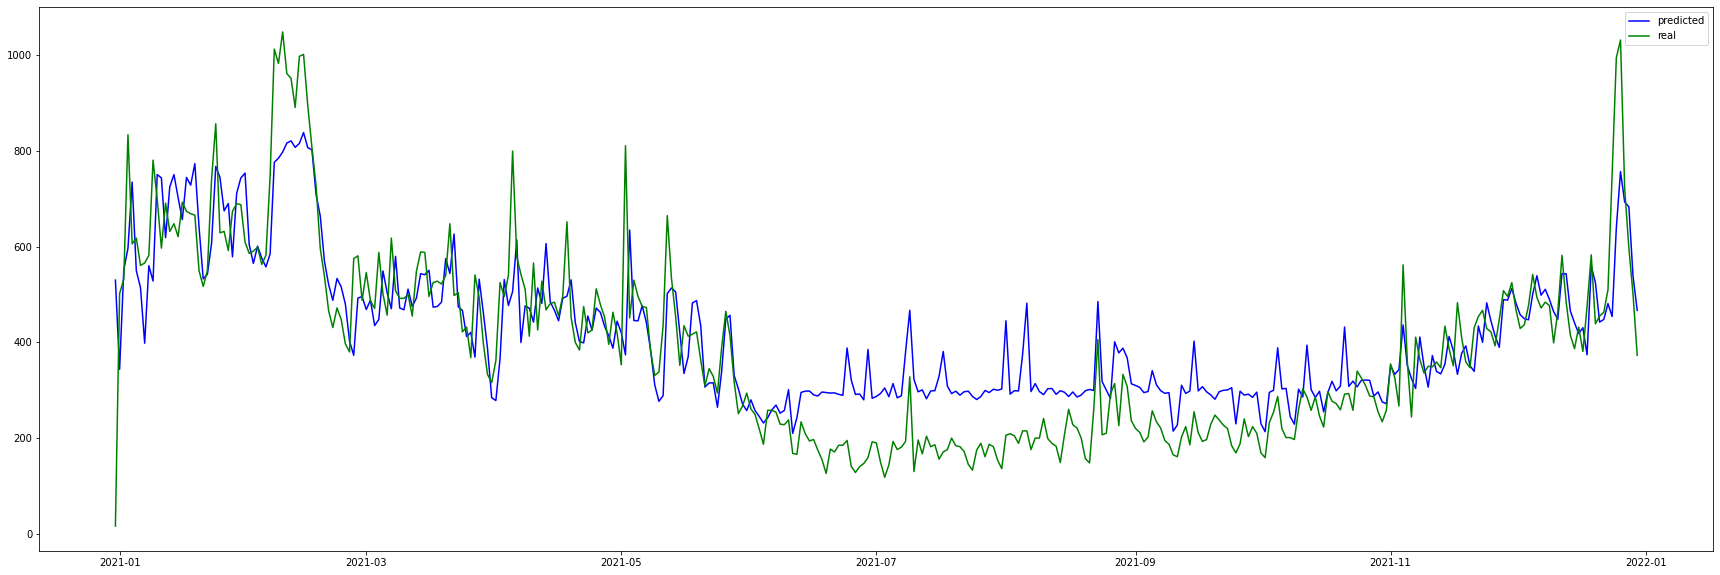

In [8]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
start_model(model,X_train,y_train,X_test,y_test)

In [14]:
feature_importances = pd.DataFrame(model.feature_importances_, index =X_test.columns,  columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
Yesterday,0.770585
bike_count,0.063864
bike_count,0.055122
Last_Week,0.038801
temp,0.023101
Yesterday_Diff,0.012851
rain,0.011807
Last_Week_Diff,0.009678
Last_Year_Diff,0.007600
Last_Year,0.006229
